# Tutorial 1

In this session, we will look at the wikileaks dataset and learn how to start gathering statistics about the dataset, preprocess the emails and extract useful information.

https://en.wikipedia.org/wiki/2016_Democratic_National_Committee_email_leak
https://wikileaks.org/dnc-emails/

## DNC emails

Around 40 000 emails leaked from DNC, around 1000 distinct users.

I give you an already pre-processed dataset in .json, where the emails are a bit cleaned and put into a 'nice' structure. If you are interested in the process of crawling + generating this file, find me later or watch the repository: https://github.com/hanveiga/nlp-amld-2018

## Loading JSON file

In the folder you will find a json file.

In [1]:
import pandas as pd

path_data = '../../data/clean_json.json'

def load_json_data(path_to_file):
    data_DF = pd.read_json(path_to_file,encoding='ascii')
    data_DF['from'] = data_DF['from'].str.lower()
    data_DF['body'] = data_DF['body'].apply(lambda x: " ".join(str(x).split()))
    return data_DF #[0:12000]

# I did this to speed up the computation a bit, you should play with this later, using the full dataset!
# return data_DF

Loading dataset from data folder

In [2]:
data = load_json_data(path_data)

Defining the Dataset object

In [3]:
data = data[0:10000]

                                                    body                date  \
0      How many more states can we get to follow Conn... 2016-05-18 02:51:22   
1      She maxed out to us earlier this year total un... 2016-05-04 13:58:23   
100    Jordan KaplanNational Finance DirectorDemocrat... 2016-04-25 18:54:17   
10000  NEGATIVE-REPUBLICANS Donald Trump’s Strange Wo... 2016-04-28 12:04:05   
10001  Looks good. Please don’t forgot to change the ... 2016-05-20 18:30:27   
10002  Wow. Could blast this out too. SL: BREAKING: N... 2016-05-20 14:21:08   
10003  5/18/2016 NATIONAL VIDEO REPORT CBS This Morni... 2016-05-18 16:20:49   
10004  Certainly we will have to address what’s happe... 2016-05-19 16:39:19   
10005  DNC Talking Points Cruz Out, Trump is the GOP ... 2016-05-04 02:02:56   
10007  I’m merging. eVeryone else hold off. Luis Mira... 2016-05-04 00:58:07   
10008  Yes. We took out the last line about Clinton s... 2016-04-27 00:57:24   
10009                                   

In [12]:
from collections import defaultdict, Counter
import nltk
#from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import string

nltk.download("stopwords")
stop_words_list = stopwords.words('english') + list(string.punctuation) #TODO: add other words?

class Dataset(object):
    def __init__(self, dataframe):
        self.data = dataframe
        self.user_emails = list(set(self.data['from']))
        self._generate_email2name()
        self.get_total_vocabulary()
        self.word_count = Counter()
        self.stop_words_list = stop_words_list
        

    def _generate_email2name(self):
        self.EMAIL2NAME = defaultdict(list) # in case there are aliases
        user_emails = self.data['from']
        user_names = self.data['from_name']
        receivers = self.data['to']
        for email, name in zip(list(user_emails),list(user_names)):
            email = email.lower()
            name = name.replace('"','')
            if name not in self.EMAIL2NAME[email]:
                self.EMAIL2NAME[email].append(name)

        receivers_emails = []
        for receiver in list(receivers):
            for name, email in receiver:
                email = email.lower()
                name = name.replace('"','')
                if name not in self.EMAIL2NAME[email]:
                    self.EMAIL2NAME[email].append(name)

    def get_top_spammers(self, ntop=9999):
        print("Count \t Email \t \t \t Name")
        list_spammers = []
        printout = 0
        for a in self.data.groupby(self.data['from'])['from'].count()\
                                        .reset_index(name='count') \
                                        .sort_values(['count'], ascending=False)\
                                        .iterrows():
                _, email = a
                if printout < ntop:
                    print("%i \t %s \t %s" %(email['count'],email['from'],self.EMAIL2NAME[email['from']][0]))
                    printout += 1
                    list_spammers.append([email['count'],email['from'],self.EMAIL2NAME[email['from']][0]])
        return list_spammers
            
    def get_total_vocabulary(self):
        #returns a dict of emails and their respective vocab
        self.vocabulary = self.data['body'].str.cat(sep=' ') + self.data['subject'].str.cat(sep=' ')
        return self.vocabulary
    
    def get_vocabulary_count(self,stop_words=False):
        if stop_words:
            self.word_count = Counter([x for x in self.vocabulary.split(' ') if x not in self.stop_words_list])
        else:
            self.word_count = Counter([x for x in self.vocabulary.split(' ')])
        return self.word_count
    
    def get_top_words(self,stop_words=False):
        if len(self.word_count.keys())==0:
            self.get_vocabulary_count(stop_words=stop_words)
        print('Word \t Count')
        for a,b in self.word_count.most_common(20):
            print('%s \t %i)' %(a, b))
        return self.word_count.most_common(20)
        
    def generate_reduced_dataset(self, list_of_users):
        pass
        #returns a smaller dataframe

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skynet/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's explore this dataset a bit.

1. For example, who sends out most emails?

In [6]:
# Initiate the dataset
DataObject = Dataset(data)

# TODO:
tab = DataObject.get_top_spammers(ntop=10)


Count 	 Email 	 	 	 Name
1780 	 mirandal@dnc.org 	 Miranda, Luis
1518 	 hendricksl@dnc.org 	 Hendricks, Lauren
1319 	 brinsterj@dnc.org 	 Brinster, Jeremy
1110 	 walkere@dnc.org 	 Walker, Eric
1104 	 dncpress@dnc.org 	 DNC Press
1098 	 sargem@dnc.org 	 Sarge, Matthew
1077 	 freundlichc@dnc.org 	 Freundlich, Christina
1032 	 comers@dnc.org 	 Comer, Scott
892 	 garciaw@dnc.org 	 Garcia, Walter
889 	 bhatnagara@dnc.org 	 Bhatnagar, Akshai


2. Which words are most common?

In particular, how can we improve the output of question 2 (if the most common words aren't particularly interesting?)

In [7]:
word_count = DataObject.get_top_words()

Word 	 Count
the 	 582792)
to 	 411832)
of 	 286168)
and 	 285184)
a 	 251727)
in 	 212081)
that 	 159347)
for 	 148611)
on 	 141931)
is 	 126653)
Trump 	 111331)
- 	 93388)
with 	 88619)
I 	 81842)
he 	 75887)
have 	 75697)
be 	 75553)
at 	 74138)
PM 	 73430)
his 	 69326)


That doesn't seem very relevant... How can we find more relevant words?

Hint:
Try modifing 

~~~
stop_words_list = stopwords.words('english') + list(string.punctuation) 
~~~

In [13]:
# Initiate the dataset again
DataObject.get_vocabulary_count(stop_words=True)
word_count = DataObject.get_top_words()

Word 	 Count
Trump 	 111331)
I 	 81842)
PM 	 73430)
2016 	 67980)
The 	 66008)
· 	 53101)
May 	 52171)
Subject: 	 46889)
From: 	 46479)
Democratic 	 46336)
To: 	 46042)
Sent: 	 45427)
would 	 43856)
Donald 	 42110)
– 	 40382)
said 	 39250)
RE: 	 36435)
Republican 	 36106)
National 	 33004)
-- 	 32753)


Try extending the stop_words_list by
~~~
DataObject.stop_words_list = stop_words_list + ...
~~~

In [ ]:
DataObject.stop_words_list = stop_words_list + ["RE:", "Sent:"]
DataObject.get_vocabulary_count(stop_words=True)
word_count = DataObject.get_top_words()

### One last question...
When do people email the most?

/Users/skynet/anaconda/envs/hackzh/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


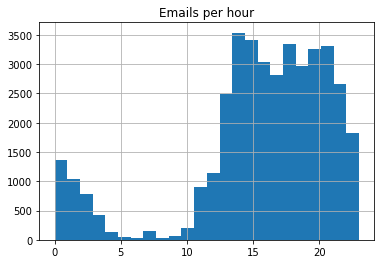

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_time(dataframe):
    new = dataframe[['date']]
    new['hour'] = pd.DatetimeIndex(new['date']).hour
    new['hour'].hist(bins=24)
    plt.title('Emails per hour')
    
plot_time(DataObject.data)

# PART 2: Exploring the user

Now let's try to get a feeling of what these people are talking about.

In this example, we will do a simple topic mining model and use spacy to pick up on relevant entities.

In particular:
1. Aggregate the communication between two people
1. Perform topic modelling on the subset exchanged emails
2. Perform named entity extraction on the subset

The output of this task is to find pairs of people and the keywords/topics they are talking about in their emails.

In [18]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nlp = spacy.load('en')
#list_of_entities = nlp.entity.cfg[u'actions']['1']
relevant_entities = ['EVENT','FAC','GPE','LAW','NORP','LOC','ORG','PRODUCT', 'PERSON']

def clean_text(text):
    return text

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            topics.append(feature_names[i])
        
    return topics

def get_keywords(sentence):
    keywords = defaultdict(list)
    doc = nlp(sentence)
    for ent in doc.ents:
        if ent.label_ in relevant_entities:
            keywords[ent.label_].append(ent.text)
    return keywords

def get_topics(emails):
    # eats a list of emails and returns 3 topics 
    # NMF is able to use tf-idf
    temp = []
    for em in emails:
        try:
            accum = [a for a in em[0].split('.')]
            temp += accum
        except:
            continue
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=False)
    tfidf = tfidf_vectorizer.fit_transform(temp)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(stop_words='english', lowercase=False)
    tf = tf_vectorizer.fit_transform(temp)
    tf_feature_names = tf_vectorizer.get_feature_names()

    no_topics = 5

    # Run NMF
    nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    # Run LDA
    lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    no_top_words = 3
    topics1 = display_topics(nmf, tfidf_feature_names, no_top_words)
    topics2 = display_topics(lda, tf_feature_names, no_top_words)
    return topics1 + topics2

class user(object):
    def __init__(self, data, email):
        self.user = email
        self.emails = data.data.loc[data.data['from']==self.user]['body']
        self.vocabulary_raw = self.get_vocabulary(data)
        self.keywords = defaultdict(list)
        self.correspondents_count = Counter()
        self.correspondents_emails = defaultdict(list)
        self.correspondents_keywords = defaultdict(dict)
        self.get_connections(data)
        self.correspondents_topics = defaultdict(list)
        self.get_topics_correspondents()
        self.connections = self.correspondents_count.keys()

    def get_vocabulary(self, data):
        return data.data.loc[data.data['from']==self.user]['body'].str.cat(sep=' ')
    
    def get_connections(self,data):
        # return person, number of emails, top entities
        self.keywords_per_receiver = defaultdict(dict)
        for row in data.data.loc[data.data['from']==self.user].itertuples():
            indx, body, date, sender, from_name, subject, corres = row
            #try:
            if len(corres) == 0:
                continue
            for r in corres[0]:
                    if '@' not in r:
                        pass
                    else:
                        r = r.lower()
                        self.correspondents_count[r] += 1
                        self.correspondents_emails[r].append([clean_text(body)])
                        keywords = get_keywords(clean_text(body))
                        
                        if r not in self.correspondents_keywords.keys():
                            for key in relevant_entities:
                                self.correspondents_keywords[r][key] = []
                        for key in keywords.keys():
                            if key in relevant_entities:
                                self.correspondents_keywords[r][key] += keywords[key]
                                
        for receiver in self.correspondents_emails.keys():
            for row in data.data.loc[data.data['from']==receiver].itertuples():
                indx, body, date, sender, from_name, subject, corres = row
                if len(corres) == 0:
                    continue
                if self.user not in corres[0]:
                    continue
                    
                self.correspondents_emails[receiver].append(str(body))
                keywords = get_keywords(body)
                        
                if receiver not in self.correspondents_keywords.keys():
                    #instanciate dictionary
                    for key in relevant_entities:
                        self.correspondents_keywords[receiver][key] = []
                        
                for key in keywords.keys():
                    if key in relevant_entities:
                        self.correspondents_keywords[receiver][key] += keywords[key]
    
    def get_topics_correspondents(self):
        for corres in self.correspondents_keywords.keys():
            try:
                topics = get_topics(userA.correspondents_emails[corres])
            except:
                topics = []
            counter = Counter(topics)
            self.correspondents_topics[corres] = counter.most_common(5)

Suppose now we are interested in looking at a person in particular. For example, some names were particularly centered in the controversy, such as:

Debbie Wasserman (email: hrtsleeve@gmail.com)     
Brad Marshal (email: marshall@dnc.or)       
Luis Miranda (mirandal@dnc.org) (he's just the top spammer :) )


~~~
python -m spacy download en
~~~


In [16]:
userA = user(DataObject,"hrtsleeve@gmail.com")
userB = user(DataObject, "marshall@dnc.or")

Interesting methods of the user object:
1. user.correspondents_emails
2. user.vocabulary_raw

In [21]:
vocab = userA.vocabulary_raw
vocab_list = vocab.split(' ')
print(Counter(vocab_list).most_common())

[('the', 193), ('to', 148), ('and', 90), ('a', 79), ('that', 70), ('is', 60), ('of', 59), ('in', 54), ('for', 48), ('Wasserman', 43), ('I', 34), ('on', 32), ('Schultz', 27), ('have', 27), ('it', 26), ('be', 24), ('this', 22), ('at', 22), ('his', 22), ('he', 22), ('We', 21), ('was', 21), ('with', 21), ('been', 20), ('you', 20), ('she', 20), ('we', 20), ('Sanders', 20), ('Debbie', 18), ('her', 18), ('about', 18), ('by', 18), ('has', 17), ('The', 17), ('my', 16), ('DNC', 16), ('as', 15), ('not', 14), ('one', 14), ('they', 14), ('are', 14), ('from', 14), ('when', 13), ('—', 12), ('tax', 12), ('Democratic', 11), ('This', 11), ('Trump', 11), ('do', 11), ('just', 11), ('but', 11), ('if', 11), ('up', 11), ('can', 10), ('Chair', 10), ("Schultz's", 10), ('first', 10), ('an', 10), ('Clinton', 10), ('get', 10), ('said', 10), ('what', 9), ('had', 9), ('there', 9), ('should', 9), ('going', 9), ('need', 9), ('me', 8), ('so', 8), ('right', 8), ('no', 8), ('made', 8), ('As', 8), ('being', 8), ('Jones',

Ew, can we get something more representative?
Hint: Remove some words...

In [24]:
stop_words_list = stopwords.words('english') + list(string.punctuation) #TODO: add other words?
vocab = [a for a in vocab_list if a not in stop_words_list]
print(Counter(vocab).most_common())

[('Wasserman', 43), ('I', 34), ('Schultz', 27), ('We', 21), ('Sanders', 20), ('Debbie', 18), ('The', 17), ('DNC', 16), ('one', 14), ('tax', 12), ('—', 12), ('Trump', 11), ('This', 11), ('Democratic', 11), ('Clinton', 10), ("Schultz's", 10), ('first', 10), ('Chair', 10), ('get', 10), ('said', 10), ('going', 9), ('need', 9), ('right', 8), ('made', 8), ('As', 8), ('Jones', 8), ('Bernie', 8), ('would', 8), ('time', 7), ('President', 7), ('She', 7), ('primary', 7), ('part', 7), ('went', 6), ('arrested', 6), ('make', 6), ('fair', 6), ('like', 6), ('it.', 6), ('top', 6), ('fuel', 6), ('says', 6), ('Here', 6), ('–', 6), ('already', 6), ('people', 6), ('behavior', 6), ('returns', 6), ('said.', 5), ('things', 5), ('held', 5), ('Okay.', 5), ('problem', 5), ('edit', 5), ('changes.', 5), ('families', 5), ('think', 5), ('added', 5), ('election', 5), ('Alaska', 4), ('Committee', 4), ('judged', 4), ('If', 4), ('Chairwoman', 4), ('call', 4), ('state', 4), ('done', 4), ('clear', 4), ('criticizing', 4), 

In [25]:
print(userA.correspondents_emails)

defaultdict(<class 'list'>, {'paustenbachm@dnc.org': [['Damn liar. Particularly scummy that he barely acknowledges the violent and threatening behavior that occurred.'], ['I am for the second one. What do others think?'], ['Shocker.'], ['#hypocrite'], ['#hypocrite'], ['Damn liar. Particularly scummy that he barely acknowledges the violent and threatening behavior that occurred.'], ['I am for the second one. What do others think?'], ['Sorry, remove double use of and in my edit before sending.'], ['We MUST issue a statement from me asap. Please forward a draft that is worded strongly.'], ['Sorry, remove double use of and in my edit before sending.'], ['We MUST issue a statement from me asap. Please forward a draft that is worded strongly.'], ['Oh grrrreeaattt.'], ['Here it is with my changes in the preamble and to my statement. Thanks everyone.'], 'Ted Cruz Declines to Support Donald Trump, and Muses About Re-entering Race 1:04 PM ET By Matt Flegenheimer In his first interview since leav

In [26]:
#email = "mirandal@dnc.org"
#userC = user(DataObject, email)

print(userC.correspondents_emails)

## Part 3: 
Now let's do the last part of this session, let's see if we can extract some interesting topics from the emails.
In particular, we want to find what person A and person B are talking about.

We are interested in looking at the function:

1. user.get_topics_correspondents     
2. get_topics   
3. get_keywords

Defined above!

In [ ]:
def get_top_words(dictionary, exclude=[]):
    all_words = []
    if len(dictionary['topics'])==0:
        pass
    else:
        for a,b in dictionary['topics']:
            all_words.append(a)
    for key in list(dictionary['keywords'].keys()):
        temp = []
        if len(dictionary['email'])==0:
            return 
        temp = dictionary['keywords'][key]
        if len(temp) < 2:
            continue
        count = Counter(temp)
        for a, b in count.most_common(1): #for example 
            all_words.append(a)
            
    all_words = [a for a in all_words if a not in exclude]
    
    print('Email: ', dictionary['email'], 'To: ', dictionary['correspondent'],\
          'Words: ', all_words)

In [ ]:
graph = []

#TODO:
email = "hrtsleeve@gmail.com"
userA = user(DataObject,email)
for key in userA.correspondents_count.keys():
        graph.append({'email': email, 'correspondent': key, 'topics': userA.correspondents_topics[key], 'keywords': userA.correspondents_keywords[key], 'count': userA.correspondents_count[key]})

import pickle        
pickle.dump(graph, open('graph_topics_dict_t.pkl','wb'))
#a = pickle.load(open('graph_topics_dict_t.pkl','rb'))

In [ ]:
for e in graph:
    exclude_words = []
    get_top_words(e, exclude = exclude_words)

In [ ]:
#exclude_words = [DataObject.EMAIL2NAME[e['email']][0], DataObject.EMAIL2NAME[e['correspondent']][0], e['email'], e['correspondent'],\
#                    ] + DataObject.EMAIL2NAME[e['email']][0].split(',') + DataObject.EMAIL2NAME[e['correspondent']][0].split(',')
    

Maybe we can look at the top spammers keywords.

In [ ]:
tab = DataObject.get_top_spammers(ntop=10)
top_s = [a[1] for a in tab]

graph = []

for email in top_s[0:10]:
    userA = user(DataObject,email)
    for key in userA.correspondents_count.keys():
        graph.append({'email': email, 'correspondent': key, 'topics': userA.correspondents_topics[key], 'keywords': userA.correspondents_keywords[key], 'count': userA.correspondents_count[key]})

for e in graph:
    exclude_words = []
    get_top_words(e, exclude = exclude_words)